### Notebook for identifying topics in AI_contracts_summaries dataset
#### This notebook pre-process the "Description" column in a dataset using various techniques, including NLTK and Gensim for tokenization, stopword removal, stemming, and lemmatization. Then use the LDA model for topic modeling, extracting and displaying topics, and assigning the dominant topic to each document in the DataFrame.
#### **Note:** This is preliminary attempt to identify the topics using unsupervised machine learning technique, the following notebook tackles same problem using LLMs.
- [AI topics `sam.gov`](https://github.com/HHS/acf-nlp-on-gfe-testing/blob/main/code/use_cases_topics_sam_csv_s3.ipynb)
- [AI techniques and usecases `sam.gov attachments`](https://github.com/HHS/acf-nlp-on-gfe-testing/blob/main/code/use_cases_topics_sam_attachments_s3.ipynb)
- [AI techniques and topics `ai.gov, hhs.gov`](https://github.com/HHS/acf-nlp-on-gfe-testing/blob/main/code/use_cases_topics_s3.ipynb)
#### Files needed to run the notebook:
        -- 'AI_contracts_summaries.csv'
#### Files generated from the notebook:
        -- 'AI_contracts_topics.csv'

#### Import libraries for data handling, text processing, and nltk library necessary for performing NLP

In [20]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk import pos_tag
import re
import itertools
import gensim
from gensim import corpora
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sankar.kalaga\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#### Load the dataset from CSV and display the frequency of values in the 'keyword' column

In [21]:
filtered_df = pd.read_csv("AI_contracts_summaries.csv")
filtered_df['keyword'].value_counts().reset_index()

index  keyword
0                        robot       83
1                          ai        25
2      artificial intelligence       19
3             machine learning       11
4              cloud computing       10
5                deep learning        3
6                 data science        2
7                         iot         2
8  natural language processing        1

#### Standardize terminology in `keyword` and `Description` columns

In [22]:
# Standardize terminology in 'keyword' and 'Description' columns by replacing spaces with hyphens in multi-word terms
filtered_df['keyword']=filtered_df['keyword'].str.replace(' ai ', 'artificial-intelligence')
filtered_df['keyword']=filtered_df['keyword'].str.replace('artificial intelligence', 'artificial-intelligence')
filtered_df['keyword']=filtered_df['keyword'].str.replace('machine learning', 'machine-learning')
filtered_df['keyword']=filtered_df['keyword'].str.replace('cloud computing', 'cloud-computing')
filtered_df['keyword']=filtered_df['keyword'].str.replace('deep learning', 'deep-learning')
filtered_df['keyword']=filtered_df['keyword'].str.replace('data science', 'data-science')
filtered_df['keyword']=filtered_df['keyword'].str.replace(' iot ', 'internet-of-things')
filtered_df['keyword']=filtered_df['keyword'].str.replace('natural language processing', 'natural-language-processing')

# Apply similar standardization to the 'Description' column and convert all text to lowercase for consistency
filtered_df['Description']=filtered_df['Description'].str.lower()
filtered_df['Description']=filtered_df['Description'].str.replace(' ai ', ' artificial-intelligence ')
filtered_df['Description']=filtered_df['Description'].str.replace('machine learning', 'machine-learning')
filtered_df['Description']=filtered_df['Description'].str.replace('cloud computing', 'cloud-computing')
filtered_df['Description']=filtered_df['Description'].str.replace('deep learning', 'deep-learning')
filtered_df['Description']=filtered_df['Description'].str.replace(' iot ', 'internet-of-things')
filtered_df['Description']=filtered_df['Description'].str.replace('natural language processing', 'natural-language-processing')

In [23]:
#  display the updated frequency of values in the 'keyword' column
filtered_df['keyword'].value_counts().reset_index()

index  keyword
0                        robot       83
1      artificial-intelligence       44
2             machine-learning       11
3              cloud-computing       10
4                deep-learning        3
5                 data-science        2
6           internet-of-things        2
7  natural-language-processing        1

#### Adding custom stopwords based on the topics identified

In [24]:
custom_stopwords = {'system','requirements','schedule', 'contracts', 'agreement', 'project', 'contract', 'solicitation',
                    'small','new','evaluation','contracting','services','sources',"firm","fixed", "purchase","price",
                    'government', 'contractor', 'contractor/subcontractor', 'award', 'companies', 'responses' ,
                    "large" , "requirement", "center", "use", "market" , "license","llc","inc",'vendor', 'quote'
                    "use", "information", "notice", "resultant", "appropriate" , "available" , "respondents" ,"future","business",
                    "institute", "northwest" , "build", "extractions" , "pacific" , "memorial", 'sdvosb'
                    "cup", "application", "size", "cuts", "trays", "release", "work", "support", "regarding", "questions", "request", "changes", "draft", "section",
                    "vinci", "year", "stapler", "davinci", "customer", "box", "description", "kit", "service", "disposal", "sureform", "reprocessing",
                    "specifications", "days", "address", "licensing", "information", "following", "email", "control", "drawings", 
                    "unit", "service", "including", "standards", "systems", "contract", "privacy", "order", "work", "officer",
                    "inc", "services", "part", "consulting", "number", "group", "sam", "product", "statement", "management",
                    "order", "including", "quotations", "items", "quotation", "program", "terms", "quoters", "support", "system",
                    "number", "payment", "service", "experience", "performance", "contract", "support", "request", "delivery", "customer", "following", "personnel", "including", "date", "items", "name",
                    "acquisition", "provisions", "offeror", "terms", "text", "provision", "service", "offer", "time", "following", "clause", "number",
                    "systems", "request", "part", "access", "using", "management", "option",
                    "conditions", "work", "response", "resources", "performance","meeting", 'solution',
                    "concern", "construction", "contract", "clause", "case", "term", "time", "cfr", "including",
                    "items", "following", "name", "number", "offerors", "solicitation", "description", "accordance", "questions", "clauses", "part", "response", "submission", "size", "provisions", "display",    "basket", "partner", "persons", "partners", "work", "size",                   
                    "field", "review", "set", "page", "literature",
                    "impacts", "factors", "insights", "effects", "office", "plan", "action",
                    "day", "modification", "synopsis", "parties", "company", "oci", "communities", "issues", "amendments", "posting", "value", "announcement",
                    "proposal", "proposals", "factors", "providing", "intent", "authority", "period", "pool",
                    "programs", "searches", "investors", "chains",
                    "procedures", "quoter", "capability", "point", "line", "view",
                    "reference", "businesses", "pages", "review", "site", "announcement",
                    "area", "volume", "index", "approach",'submit', 'task', 'rights',
                    "cost", "examples", "proposal", "operations", "diamond", "event",'cor', 'e-mail', 'hours','pop',
                    "day", "item", "line", "supplies", "procedures", "cost", "period", "end", "subcontracting",
                    "mail", "day", "comments", "tax", "point", "source", "list", "agents", "room", "telephone", "needs", "phone", "point_of_contact", 'brochurepdf', 'inc',
                    'feb', 'nov', 'copy', 'effect', 'june', 'aug', 'ii','dec', 'vaar',  'los', 'angeles', 'act', 'https//technologynasagov/', 'jan', 'feb', 'please',
                    "representation", "material","purpose","quote", "describe","time","mar","mode","set_aside","oct","file","one_on_one",
                    "self_service","months","parking","pet"
                    }

#### This following code pre-processes the "Description" column in a dataset using NLTK library. It then uses the LDA model to identify topics, extracts words associated with each topic, and assigns the dominant topic to each contract description in the DataFrame.

In [26]:
final_topic_list=[]
# Extend the default NLTK stopwords with custom stopwords
stop_wordsn = set(stopwords.words('english')).union(custom_stopwords)

# Basic preprocessing steps including lowering case, replacing hyphens, and removing stopwords
def nltk_preprocess(text):
    text = text.lower().split()
    text=[term.replace('-', '_') for term in text]
    text = [word for word in text if word not in stop_wordsn and len(word) > 2 and len(word) < 30 ]
    filtered_list = [item for item in text if not re.search(r'[a-zA-Z].*\d|\d.*[a-zA-Z]', item)]
    filtered_list = [item for item in filtered_list if not item.isdigit()]
    filtered_list=[item.replace('(', '').replace(')', '').replace(',', '').replace('.', '').replace('?', '').replace(';', '').replace(':', '').replace('[', '').replace(']', '').replace('*', '').replace('“', '').replace('”', '').replace('#', '') for item in filtered_list]
    # filtered_list=list(set(filtered_list))
    topics= [item for item in filtered_list if not re.search(r'\d', item)]
    tagged_words = pos_tag(topics)
    tagged_words = [(term.replace('_', '-'), tag) for term, tag in tagged_words]
    technical_terms = [word for word, tag in tagged_words if tag in ('NN', 'VBG', 'NNS')]#('JJ','NN','VBP','NNS','VBZ','IN','VBD', 'VBG')]
    technical_terms=[term.strip() for term in technical_terms]
    result=[]
    for token in technical_terms:
        if token not in stop_wordsn and len(token) > 2:
            # result.append(lemmatize_stemming(token))
            result.append(token)
    return result
    # return technical_terms

# Apply the preprocessing function to the 'Description' column
filtered_df['Description_Processed_nltk'] = filtered_df['Description'].apply(nltk_preprocess)
# filtered_df['Description_Processed'] = filtered_df['Summary_without_preprocessing'].apply(nltk_preprocess)

#  Creating dictionary and corpus for LDA analysis
dictionary = corpora.Dictionary(filtered_df['Description_Processed_nltk'].tolist())
corpus = [dictionary.doc2bow(text) for text in filtered_df['Description_Processed_nltk']]

# Running LDA Model to identify topics
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word=dictionary, passes=500)
topics = lda_model.print_topics(num_words=30)

# Extract and print words associated with each topic
def extract_words(topic_str):
    words = []
    parts = topic_str.split(' + ')
    for part in parts:
        word = part.split('*')[1].strip().replace('"', '')
        words.append(word)
    return words

# Process and print each topic
for topic_num, topic in topics:
    words = extract_words(topic)
    final_topic_list.append(words)
    print(f"Topic {topic_num}:", ", ".join(words))
    

# Assigning topics to DataFrame
def get_dominant_topic(lda_model, corpus):
    # Find the dominant topic for each document
    topics = []
    for doc_bow in corpus:
        doc_topics = lda_model.get_document_topics(doc_bow)
        dominant_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0][0]
        topics.append(dominant_topic)
    return topics

filtered_df['Dominant_Topic_NLTK'] = get_dominant_topic(lda_model, corpus)


Topic 0: certification, veterans, sdvosb, database, materials, naics, firms, percent, veteran, amount, limitations, venture, sdvosbs, excluding, status, supply, pay, department, contractors, limitation, portion, surviving, affairs, sba, pursuant, offers, resulting, regulations, disability, trade
Topic 1: data, equipment, solutions, technologies, installation, engineering, technology, corporation, software, research, science, steris, integration, power, impact, machine-learning, efficiency, analytics, facility, amsco, return, oasis, rack, location, awards, applications, steam, development, instrument, design
Topic 2: document, research, visualization, ion, devices, naics, equipment, industry, technology, provide, department, veterans, installation, addition, state, integration, console, design, note, manufacturing, software, rfi, computer, clin, data, code, classification, nist, receipt, herein
Topic 3: equipment, maintenance, products, software, precision, robot, characteristics, certi

In [27]:
# Display the DataFrame with descriptions, keywords, and dominant topics obtained from NLTK
display(filtered_df[['Description', 'keyword','Dominant_Topic_NLTK']])

Description  \
0    sam.gov sources sought notice solicitation num...   
1    the bureau of land management intends to utili...   
2    number: 36c10g24r0012 notice type: combined sy...   
3               robotic prescription dispensing system   
4    combined synopsis/solicitation notice combined...   
..                                                 ...   
151  sbir phase ii proposal #b20p2-1f01. early dete...   
152  sbir phase i proposal #b205c-0003.procuring un...   
153  nasa’s technology transfer program solicits in...   
154  oasis sb pool 4 awardees and apparent successf...   
155  oasis sb pool 3 awardees and apparent successf...   

                     keyword  Dominant_Topic_NLTK  
0               data-science                   11  
1                      robot                    7  
2                      robot                    7  
3                      robot                   12  
4                      robot                    3  
..                       ...                  ...  
151       internet-of-things                    9  
152         machine-learning                   14  
153                    robot                   10  
154  artificial-intelligence                    1  
155  artificial-intelligence                    1  

[156 rows x 3 columns]

#### This script preprocesses the "Description" column in a dataset using Gensim's stopwords combined with custom stopwords, performs tokenization, stemming, and lemmatization, and identifies technical terms. It then uses the LDA model to identify topics, prints the topics, and assigns the dominant topic to each document in the DataFrame.

In [28]:
# Define custom stopwords from Gensim's list combined with custom defined stopwords
stop_wordsg = set(gensim.parsing.preprocessing.STOPWORDS).union(custom_stopwords)

# Initialize SnowballStemmer for stemming words
stemmer = SnowballStemmer("english")

# Function to stem and lemmatize a given text
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenization and preprocessing function for text
def gensim_preprocess(text):
    text = text.lower().split()
    text=[term.replace('-', '_') for term in text]
    text = [word for word in text if word not in stop_wordsg and len(word) > 2 and len(word) < 30 ]
    filtered_list = [item for item in text if not re.search(r'[a-zA-Z].*\d|\d.*[a-zA-Z]', item)]
    filtered_list = [item for item in filtered_list if not item.isdigit()]
    filtered_list=[item.replace('(', '').replace(')', '').replace(',', '').replace('.', '').replace('?', '').replace(';', '').replace(':', '').replace('[', '').replace(']', '').replace('*', '').replace('“', '').replace('”', '').replace('#', '') for item in filtered_list]
    # filtered_list=list(set(filtered_list))
    topics= [item for item in filtered_list if not re.search(r'\d', item)]
    tagged_words = pos_tag(topics)
    tagged_words = [(term.replace('_', '-'), tag) for term, tag in tagged_words]
    technical_terms = [word for word, tag in tagged_words if tag in ('NN', 'VBG', 'NNS')]#('JJ','NN','VBP','NNS','VBZ','IN','VBD', 'VBG')]
    updated_text = ' '.join(technical_terms)
    updated_text=updated_text.replace('-','_')
    tokens=updated_text.split(' ')
    tokens=[term.strip() for term in tokens]
    result=[]
    for token in tokens:
        if token not in stop_wordsg and len(token) > 2:
            # result.append(lemmatize_stemming(token))
            result.append(token)
    return result

# Apply preprocessing to the descriptions in the dataframe
filtered_df['Description_Processed_gen'] = filtered_df['Description'].apply(gensim_preprocess)
# filtered_df['Description_Processed'] = filtered_df['Summary_without_preprocessing'].apply(gensim_preprocess)

# Creating the dictionary and corpus for LDA
dictionary = corpora.Dictionary(filtered_df['Description_Processed_gen'].tolist())
corpus = [dictionary.doc2bow(text) for text in filtered_df['Description_Processed_gen']]

# Train LDA model and print identified topics
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word=dictionary, passes=500)
topics = lda_model.print_topics(num_words=30)

# Process and print each topic
for topic_num, topic in topics:
    words = extract_words(topic)
    final_topic_list.append(words)
    print(f"Topic {topic_num}:", ", ".join(words))

# Assign dominant topic for each document
def get_dominant_topic(lda_model, corpus):
    # Find the dominant topic for each document
    topics = []
    for doc_bow in corpus:
        doc_topics = lda_model.get_document_topics(doc_bow)
        dominant_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0][0]
        topics.append(dominant_topic)
    return topics

filtered_df['Dominant_Topic_gen'] = get_dominant_topic(lda_model, corpus)

Topic 0: certification, sdvosb, veterans, database, firms, naics, materials, percent, veteran, sdvosbs, venture, limitations, excluding, supply, status, department, pay, documents, limitation, contractors, design, portion, affairs, surviving, sba, offers, resulting, pursuant, disability, trade
Topic 1: coulter, beckman, silver, respond, software, issuance, units, procurement, specialist, centers, determination, maintenance, updates, property, assures, determining, biomek, instruments, calls, negotiate, identify, prevention, stations, compete, conduct, repairs, labor, equipment, premature, pre
Topic 2: security, data, training, equipment, maintenance, records, breach, pet/ct, parts, confidentiality, incident, operation, regulations, risk, credit, employees, protection, analysis, repair, health, individuals, vamc, safety, law, quality, resolution, contractors, policies, subcontractors, camera
Topic 3: data, health, climate, change, risk, veterans, disease, analysis, integration, analytic

In [29]:
# Display the DataFrame with descriptions, keywords, and dominant topics obtained from Gensim
display(filtered_df[['Description', 'keyword' ,'Dominant_Topic_gen']])

Description  \
0    sam.gov sources sought notice solicitation num...   
1    the bureau of land management intends to utili...   
2    number: 36c10g24r0012 notice type: combined sy...   
3               robotic prescription dispensing system   
4    combined synopsis/solicitation notice combined...   
..                                                 ...   
151  sbir phase ii proposal #b20p2-1f01. early dete...   
152  sbir phase i proposal #b205c-0003.procuring un...   
153  nasa’s technology transfer program solicits in...   
154  oasis sb pool 4 awardees and apparent successf...   
155  oasis sb pool 3 awardees and apparent successf...   

                     keyword  Dominant_Topic_gen  
0               data-science                  10  
1                      robot                   9  
2                      robot                   5  
3                      robot                   8  
4                      robot                   8  
..                       ...                 ...  
151       internet-of-things                   3  
152         machine-learning                  13  
153                    robot                   4  
154  artificial-intelligence                   6  
155  artificial-intelligence                   6  

[156 rows x 3 columns]

#### This script preprocesses the "Description" column using NLTK, converts the text into TF-IDF vectors, and filters out words with low TF-IDF scores. It then uses these high TF-IDF score words to perform LDA topic modeling, extracts and displays topics, and assigns the dominant topic to each document in the DataFrame.

In [30]:
# Preprocess descriptions using NLTK, convert lists of words back into strings
filtered_df['Description_Processed_NLTK_TFIDF'] = filtered_df['Description'].apply(nltk_preprocess)
filtered_df['Description_Processed_NLTK_TFIDF'] = filtered_df['Description_Processed_NLTK_TFIDF'].apply(lambda x: ' '.join(x))

# Generate TF-IDF matrix to identify important words and set thresholds for word filtering, adjust parameters as needed
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)  
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_df['Description_Processed_NLTK_TFIDF'])

# Select words with high TF-IDF scores, adjusting the threshold as necessary, adjust threshold as needed
words = tfidf_vectorizer.get_feature_names_out()
high_tfidf_words = {word for word, score in zip(words, tfidf_matrix.sum(axis=0).A1) if score > 0.3}  

# Filter descriptions to include only high TF-IDF score words
def filter_high_tfidf(text):
    return [word for word in text.split() if word in high_tfidf_words]

filtered_df['High_TFIDF_Processed'] = filtered_df['Description_Processed_NLTK_TFIDF'].apply(filter_high_tfidf)

# Create dictionary and corpus for LDA using high TF-IDF words and perform topic modeling
dictionary = corpora.Dictionary(filtered_df['High_TFIDF_Processed'].tolist())
corpus = [dictionary.doc2bow(text) for text in filtered_df['High_TFIDF_Processed']]
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word=dictionary, passes=500)
topics = lda_model.print_topics(num_words=30)

# Display topics extracted from LDA model
for topic_num, topic in topics:
    words = extract_words(topic)
    final_topic_list.append(words)
    print(f"Topic {topic_num}:", ", ".join(words))

# Assign dominant topic for each document
def get_dominant_topic(lda_model, corpus):
    # Find the dominant topic for each document
    topics = []
    for doc_bow in corpus:
        doc_topics = lda_model.get_document_topics(doc_bow)
        dominant_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0][0]
        topics.append(dominant_topic)
    return topics

filtered_df['Dominant_Topic_TFIDF_NLTK'] = get_dominant_topic(lda_model, corpus)

Topic 0: development, design, space, radiator, analysis, technology, risk, team, radiators, safety, vehicle, propulsion, engineering, criterion, plant, reliability, members, career, partnering, industry, models, fluid, projects, points, testing, vehicles, nasa, software, demonstration, research
Topic 1: products, equipment, research, maintenance, ncats, naics, health, applies, document, catalog, availability, characteristics, ability, inspect, quantity, knowledge, classification, quotes, water, code, agency, facility, cell, telecommunications, institutes, competition, numbers, entity, perform, reserves
Topic 2: robot, device, replacement, invoice, offers, veterans, software, orders, code, disinfection, letter, affairs, characteristics, department, facility, user, training, amendment, termination, safety, receipt, naics, interest, responding, employees, classification, applies, manufacturer, demand, texas
Topic 3: security, data, training, equipment, records, maintenance, breach, parts,

In [31]:
# Display the DataFrame with descriptions, keywords, and dominant topics obtained from Gensim
display(filtered_df[['Description', 'keyword' ,'Dominant_Topic_TFIDF_NLTK']])

Description  \
0    sam.gov sources sought notice solicitation num...   
1    the bureau of land management intends to utili...   
2    number: 36c10g24r0012 notice type: combined sy...   
3               robotic prescription dispensing system   
4    combined synopsis/solicitation notice combined...   
..                                                 ...   
151  sbir phase ii proposal #b20p2-1f01. early dete...   
152  sbir phase i proposal #b205c-0003.procuring un...   
153  nasa’s technology transfer program solicits in...   
154  oasis sb pool 4 awardees and apparent successf...   
155  oasis sb pool 3 awardees and apparent successf...   

                     keyword  Dominant_Topic_TFIDF_NLTK  
0               data-science                          1  
1                      robot                          9  
2                      robot                          6  
3                      robot                         12  
4                      robot                          2  
..                       ...                        ...  
151       internet-of-things                          8  
152         machine-learning                         10  
153                    robot                          4  
154  artificial-intelligence                         10  
155  artificial-intelligence                         10  

[156 rows x 3 columns]

#### This script preprocesses the "Description" column using a custom Gensim function, converts the text into TF-IDF vectors, and filters out words with low TF-IDF scores. Using these high TF-IDF score words, it performs LDA topic modeling, extracts and displays topics, and assigns the dominant topic to each document in the DataFrame.

In [32]:
# Apply text preprocessing using a custom gensim function and convert lists of words back into strings
filtered_df['Description_Processed_GenTFIDF'] = filtered_df['Description'].apply(gensim_preprocess)
filtered_df['Description_Processed_GenTFIDF'] = filtered_df['Description_Processed_GenTFIDF'].apply(lambda x: ' '.join(x))

# Generate TF-IDF matrix for identifying important words, adjusting parameters for filtering, adjust parameters as needed
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)  
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_df['Description_Processed_GenTFIDF'])

# Determine high TF-IDF score words, setting a threshold for selection, # adjust threshold as needed
words = tfidf_vectorizer.get_feature_names_out()
high_tfidf_words = {word for word, score in zip(words, tfidf_matrix.sum(axis=0).A1) if score > 0.3}  

# Apply filtering to include only words with high TF-IDF scores in the processed texts
def filter_high_tfidf(text):
    return [word for word in text.split() if word in high_tfidf_words]
filtered_df['High_TFIDF_Processed'] = filtered_df['Description_Processed_GenTFIDF'].apply(filter_high_tfidf)

# Creating the dictionary and corpus for LDA with high TF-IDF words
dictionary = corpora.Dictionary(filtered_df['High_TFIDF_Processed'].tolist())
corpus = [dictionary.doc2bow(text) for text in filtered_df['High_TFIDF_Processed']]

# Train an LDA model to identify topics from the corpus
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word=dictionary, passes=500)
topics = lda_model.print_topics(num_words=30)

# Print extracted topics from the LDA model
for topic_num, topic in topics:
    words = extract_words(topic)
    final_topic_list.append(words)
    print(f"Topic {topic_num}:", ", ".join(words))

# Assign dominant topic for each document
def get_dominant_topic(lda_model, corpus):
    # Find the dominant topic for each document
    topics = []
    for doc_bow in corpus:
        doc_topics = lda_model.get_document_topics(doc_bow)
        dominant_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0][0]
        topics.append(dominant_topic)
    return topics

filtered_df['Dominant_Topic_TFIDF_Gen'] = get_dominant_topic(lda_model, corpus)


Topic 0: equipment, installation, drive, software, pharmacy, building, quotes, amendment, precision, pcie, code, writing, maintenance, condition, working, brand, materials, receipt, entity, quantity, representations, hardware, memory, destination, agency, location, certifications, street, facility, development
Topic 1: health, climate, data, change, veterans, risk, disease, emergency, healthcare, department, care, veteran, analytics, activities, staff, affairs, community, surveillance, diseases, administration, insurance, existing, platform, models, strategy, record, intelligence, integration, planning, risks
Topic 2: steris, instrument, replacement, characteristics, irrigator, surgeon, console, vendors, surgery, accessories, endowrist, guide, manufacturer, lease, angle, robot, distributor, products, veterans, brand, standard, surgeons, cannula, salient, letter, affairs, naics, function, fda, change
Topic 3: technology, visualization, products, transfer, verification, opportunity, labo

In [33]:
# Display the DataFrame with descriptions, keywords, and dominant topics obtained from Gensim
display(filtered_df[['Description', 'keyword' ,'Dominant_Topic_TFIDF_Gen']])

Description  \
0    sam.gov sources sought notice solicitation num...   
1    the bureau of land management intends to utili...   
2    number: 36c10g24r0012 notice type: combined sy...   
3               robotic prescription dispensing system   
4    combined synopsis/solicitation notice combined...   
..                                                 ...   
151  sbir phase ii proposal #b20p2-1f01. early dete...   
152  sbir phase i proposal #b205c-0003.procuring un...   
153  nasa’s technology transfer program solicits in...   
154  oasis sb pool 4 awardees and apparent successf...   
155  oasis sb pool 3 awardees and apparent successf...   

                     keyword  Dominant_Topic_TFIDF_Gen  
0               data-science                        13  
1                      robot                         7  
2                      robot                        13  
3                      robot                         0  
4                      robot                        10  
..                       ...                       ...  
151       internet-of-things                         1  
152         machine-learning                         6  
153                    robot                         3  
154  artificial-intelligence                         5  
155  artificial-intelligence                         5  

[156 rows x 3 columns]

In [34]:
# save the dataframe to a csv file
filtered_df.to_csv('AI_contracts_topics.csv')

In [35]:
final_topic_list_wc=sum(final_topic_list,[])
print(len(final_topic_list_wc))
final_topic_list_wc1=list(set(final_topic_list_wc))
# final_topic_list_wc1=[x.strip() for x in final_topic_list_wc1]
# final_topic_list_wc1=[item for item in final_topic_list_wc1 if item != 'nan']
print(len(final_topic_list_wc1))

1800
551


#### Create the WordCloud displaying the frequent words

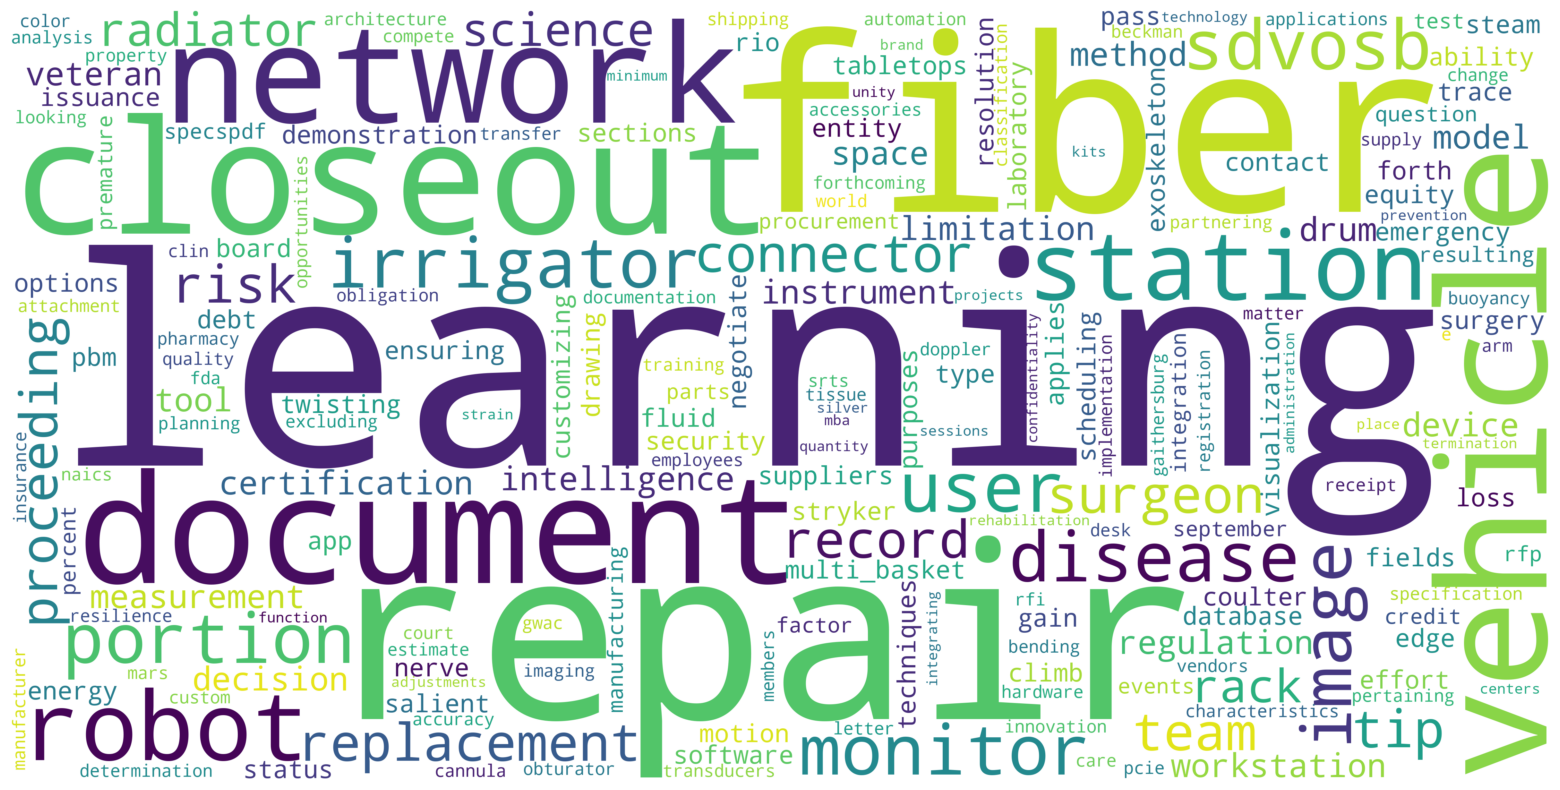

In [36]:
wordcloud = WordCloud(width=1600, height=800, background_color='white', min_font_size=10,  scale=3).generate(' '.join(final_topic_list_wc1))
# Display the generated image:
plt.figure(figsize=(20, 10)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  
plt.show()

#### This code creates a grid of subplots to display each word from `final_topic_list_wc1`

In [37]:
num_words = len(final_topic_list_wc1)
num_cols = int(np.ceil(np.sqrt(num_words)))
num_rows = int(np.ceil(num_words / num_cols))

# Create plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(200, 90))
axes = axes.flatten()  # Flatten the 2D array of axes to simplify looping
# Plot each word in its subplot
for ax, word in zip(axes, final_topic_list_wc1):
    ax.text(0.5, 0.5, word, fontsize=100, ha='center', va='center')
    ax.axis('off')  # Hide axes
# Turn off any unused subplots
for ax in axes[len(final_topic_list_wc1):]:
    ax.axis('off')
plt.tight_layout(pad=0)  
plt.show()